In [44]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

alpha = 0.05

def standardize(X):
    return (X - X.mean()) / X.std()

### Data Import & EDA

In [45]:
data = pd.read_csv('data.csv')
data.head(10)

,Census Tract,Total Population,California County,ZIP,Approximate Location,Longitude,Latitude,CES 4.0 Score,CES 4.0 Percentile,CES 4.0 Percentile Range,...,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6019001100,2780,Fresno,93706,Fresno,-119.781696,36.709695,93.18,100.00,95-100% (highest scores),...,79.37,76.0,98.92,12.8,93.83,30.3,91.04,93.16,9.66,99.72
1,6077000700,4680,San Joaquin,95206,Stockton,-121.287873,37.943173,86.65,99.99,95-100% (highest scores),...,95.53,73.2,98.39,19.8,99.21,31.2,92.28,93.17,9.66,99.74
2,6037204920,2751,Los Angeles,90023,Los Angeles,-118.197497,34.017500,82.39,99.97,95-100% (highest scores),...,81.55,62.6,93.39,6.4,61.53,20.3,63.97,83.75,8.69,95.79
3,6019000700,3664,Fresno,93706,Fresno,-119.827707,36.734535,81.33,99.96,95-100% (highest scores),...,78.71,65.7,95.35,15.7,97.35,35.4,96.41,94.64,9.82,99.89
4,6019000200,2689,Fresno,93706,Fresno,-119.805504,36.735491,80.75,99.95,95-100% (highest scores),...,86.56,72.7,98.30,13.7,95.29,32.7,94.16,95.40,9.90,99.95
5,6037542402,3306,Los Angeles,90221,Compton,-118.212413,33.881969,80.71,99.94,95-100% (highest scores),...,NaN,43.5,74.05,9.3,83.22,23.7,76.35,83.37,8.65,95.46
6,6019001000,4255,Fresno,93706,Fresno,-119.804314,36.697751,80.55,99.92,95-100% (highest scores),...,88.70,79.5,99.41,15.4,97.14,33.3,94.83,95.84,9.94,99.99
7,6037543202,5124,Los Angeles,90220,Compton,-118.230032,33.879862,79.29,99.91,95-100% (highest scores),...,60.62,56.8,88.92,12.6,93.49,29.6,89.84,85.44,8.86,96.90
8,6019001202,4561,Fresno,93725,Unincorporated Fresno County area,-119.741028,36.702685,79.17,99.90,95-100% (highest scores),...,89.62,72.2,98.12,16.3,97.90,30.8,91.76,87.24,9.05,98.05
9,6077000100,3688,San Joaquin,95202,Stockton,-121.285363,37.953996,77.87,99.89,95-100% (highest scores),...,91.39,78.8,99.31,14.6,96.46,33.1,94.64,95.83,9.94,99.97


The purpose of adding the code below is because some of the variables have spaces, which the sms library cannot read as a formula.

In [46]:
def fill_space(s):
    return s.replace(" ", "_").replace(".", "")

data_copy = data.copy()
for feature in data.columns:
    new_feature = fill_space(feature)
    if new_feature != feature:
        data[new_feature] = data[feature]
        data_copy[new_feature] = data_copy[feature]
        data = data.drop(columns=[feature])
        data_copy = data_copy.drop(columns=[feature])
    if 'Pctl' in feature:
        data_copy = data_copy.drop(columns=[new_feature])


Index(['ZIP', 'Longitude', 'Latitude', 'Ozone', 'Lead', 'Pesticides',
       'Traffic', 'Asthma', 'Education', 'Poverty', 'Unemployment',
       'Census_Tract', 'Total_Population', 'California_County',
       'Approximate_Location', 'CES_40_Score', 'CES_40_Percentile',
       'CES_40_Percentile_Range', 'Ozone_Pctl', 'PM25', 'PM25_Pctl',
       'Diesel_PM', 'Diesel_PM_Pctl', 'Drinking_Water', 'Drinking_Water_Pctl',
       'Lead_Pctl', 'Pesticides_Pctl', 'Tox_Release', 'Tox_Release_Pctl',
       'Traffic_Pctl', 'Cleanup_Sites', 'Cleanup_Sites_Pctl',
       'Groundwater_Threats', 'Groundwater_Threats_Pctl', 'Haz_Waste',
       'Haz_Waste_Pctl', 'Imp_Water_Bodies', 'Imp_Water_Bodies_Pctl',
       'Solid_Waste', 'Solid_Waste_Pctl', 'Pollution_Burden',
       'Pollution_Burden_Score', 'Pollution_Burden_Pctl', 'Asthma_Pctl',
       'Low_Birth_Weight', 'Low_Birth_Weight_Pctl', 'Cardiovascular_Disease',
       'Cardiovascular_Disease_Pctl', 'Linguistic_Isolation',
       'Linguistic_Isolation_P

We drop the education percentile variable because it carries a significant amount of information concering the education variable itself. 

In [ ]:
data = data.drop(columns=['Education_Pctl'])
data.columns

## Selecting Columns
We will focus primary on poverty level and try to find variables which we believe will correlate most with poverty level. Originally selected the following
-   Total Population
-   California County
-   Unemployment
-   Zip code
-   Poverty Percentile 
-   Lead
-   PM2.5 Pctl

But pivoted to the following

-   Total Population
-   California County
-   Unemployment
-   Zip code
-   Poverty 
-   Lead
-   PM2.5
  
The reasoning behind these choices was that if the data is already standardized it will be difficult to observed the differences between the two counties in exploration. Moreover, we swapped education and poverty because we instead want to predict education.

In [47]:
clean = data[['California_County', 'Poverty', 'Lead', 'Pollution_Burden', 'Asthma', 'Linguistic_Isolation', 'Education']].sort_values('Poverty', ascending=False)

columns = ['Poverty', 'Lead', 'Pollution_Burden', 'Asthma', 'Linguistic_Isolation', 'Education']

### Distribution of `Poverty`

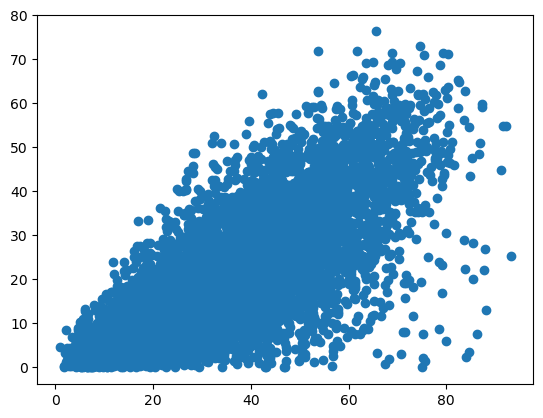

In [48]:
plt.scatter(x=clean['Poverty'],y=clean['Education'])

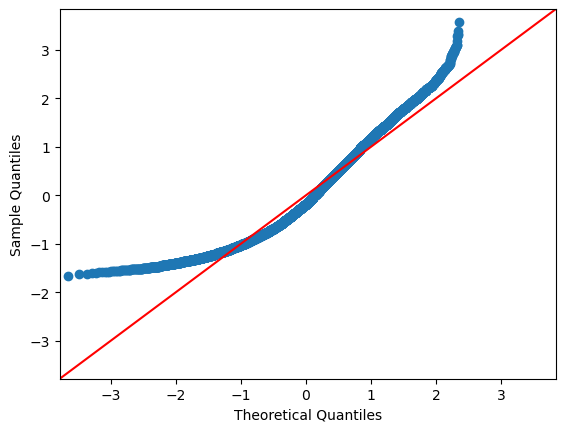

In [49]:
hide = sm.qqplot((standardize(clean['Poverty'])), stats.norm, line='45')

<Axes: xlabel='Poverty', ylabel='Count'>

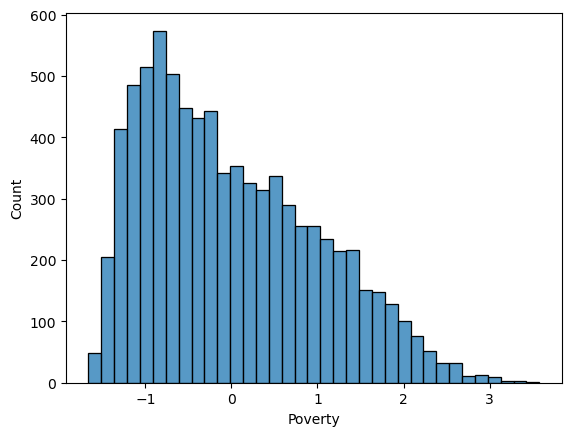

In [50]:
sns.histplot(data=standardize(data['Poverty']))

### Distribution of `Education`

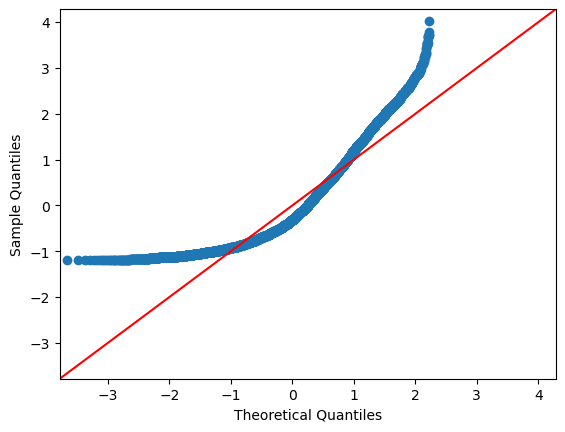

In [51]:
hide = sm.qqplot((standardize(data['Education'])), stats.norm, line='45')

<Axes: xlabel='Education', ylabel='Count'>

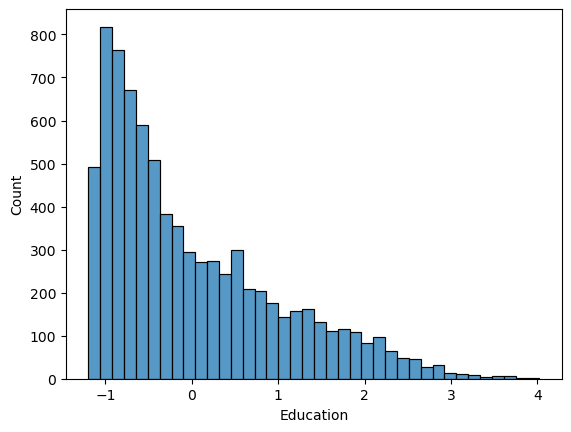

In [52]:
sns.histplot(data=standardize(data['Education']))

### Basic OLS Model

In [53]:
model_clean = smf.ols('Poverty ~ Education', clean).fit()
print(model_clean.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.2554      0.198     72.054      0.000      13.868      14.643
Education      0.9787      0.009    112.583      0.000       0.962       0.996


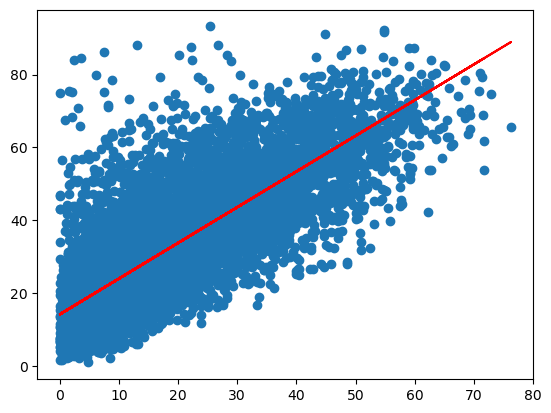

In [54]:
plt.scatter(clean['Education'], clean['Poverty'])
plt.plot(clean['Education'], model_clean.predict(clean), color='red')

Missingness?: Dropping rows where education is missing. Negligible data loss. 54 from ~2950 rows.

Five Assumptions For Lin. Regression:
1. Linear
2. Independence
3. Heteroscedasticity
4. Normally Distributed Error
5. Completeness

Our model to test:

$\hat{\text{Education}} = \text{Variables}$

The most highly correlated variables were:

- Lead: 0.64
- Pollution Burden: 0.44
- Asthma: 0.44
- Linguistic Iso.: 0.71
- Poverty: 0.78
- Unemployment: 0.39
- Housing Burden: 0.53
- Cardiovascular Disease: 0.47

But to reduce multicollinearity we narrowed it down to five variables:

- Lead: 0.64
- Pollution Burden: 0.44
- Asthma: 0.44
- Linguistic Isolation: 0.71
- Poverty: 0.78

In [55]:
def present(feature_x, feature_y):
    plt.scatter(x=clean[feature_x],y=clean[feature_y])

<Axes: >

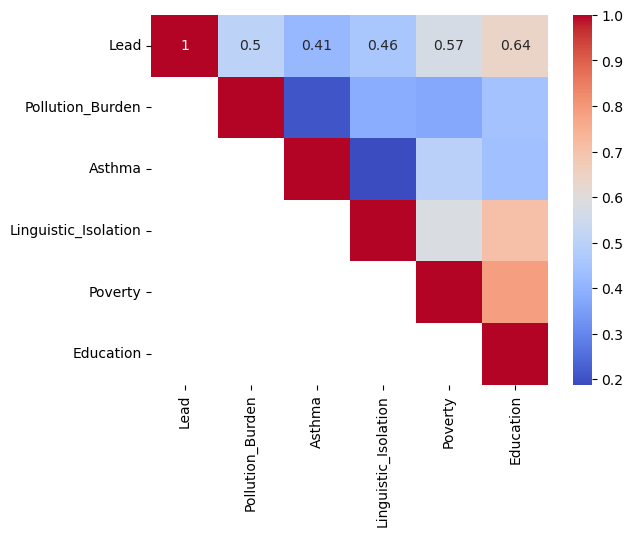

In [56]:
drop_data = data[['Lead', 'Pollution_Burden', 'Asthma', 'Linguistic_Isolation', 'Poverty', 'Education']]
variables = drop_data.columns
corr_table = drop_data[variables].corr() 
sns.heatmap(corr_table, annot=True, cmap='coolwarm', mask=np.tril(corr_table, k=-1))

### Shapiro-Wilk Test

We can run the shapiro-wilk test to check if our data is normally distributed. The anatomy of the test is the following 
$$
\begin{aligned}
H_{0}: X_{1},X_{2},...,,X_{n} \sim N(\mu,\sigma^{2}) \text{ for some } \mu \in \mathbb{R}, \sigma > 0 \\ 
H_{a}: X_{1},X_{2},...,,X_{n} \ne N(\mu,\sigma^{2}) \text{ for some } \mu \in \mathbb{R}, \sigma > 0 
\end{aligned}
$$

#### Poverty Shapiro-Wilk test

In [57]:
poverty_pval = stats.shapiro(clean['Poverty']).pvalue
if poverty_pval < alpha:
    print("REJECT NULL")
else:
    print("FAIL TO REJECT NULL")

FAIL TO REJECT NULL


/Users/albertovalencia/miniconda3/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


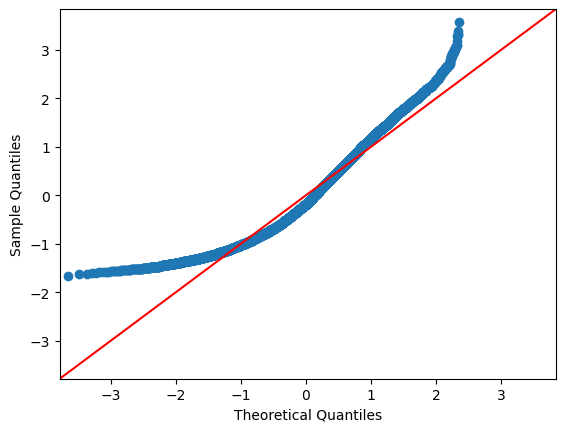

In [58]:
hide = sm.qqplot((clean['Poverty'] - clean['Poverty'].mean()) / np.std(clean['Poverty']), stats.norm, line='45')

>There seems to be evidence that the feature `Poverty` follows a normal distribution for an alpha level of .05

### Complete OLS Model

In [59]:
model = smf.ols('Education ~ Poverty + Lead + Asthma + Linguistic_Isolation + Pollution_Burden', clean).fit()

# Regression Assumptions

### Independence of residuals

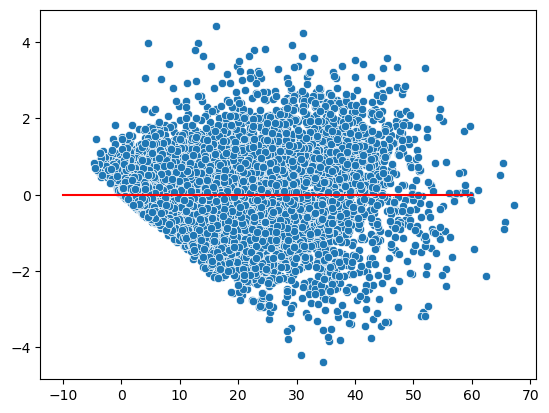

In [60]:
sns.scatterplot(x=model.fittedvalues, y=standardize(model.resid))
plt.plot(np.linspace(-10, 60, 100), np.zeros(100), 'r')

### Normality of Residuals

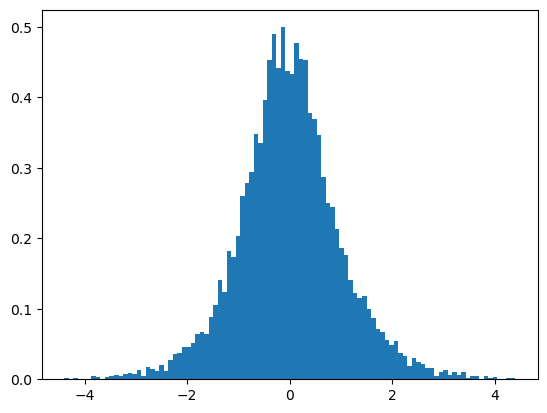

In [61]:
hide = plt.hist(standardize(model.resid), bins=100, density=True)

In [62]:
residuals_pvalue = stats.shapiro(standardize(model.resid)).pvalue
if residuals_pvalue < alpha:
    print("REJECT NULL")
else:
    print("FAIL TO REJECT NULL")

REJECT NULL


/Users/albertovalencia/miniconda3/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


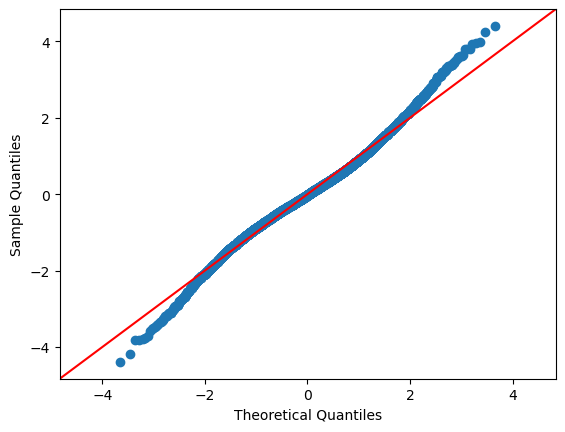

In [63]:
qq = sm.qqplot(standardize(model.resid), stats.norm, line='45')

### Check for Independence

<BarContainer object of 21 artists>

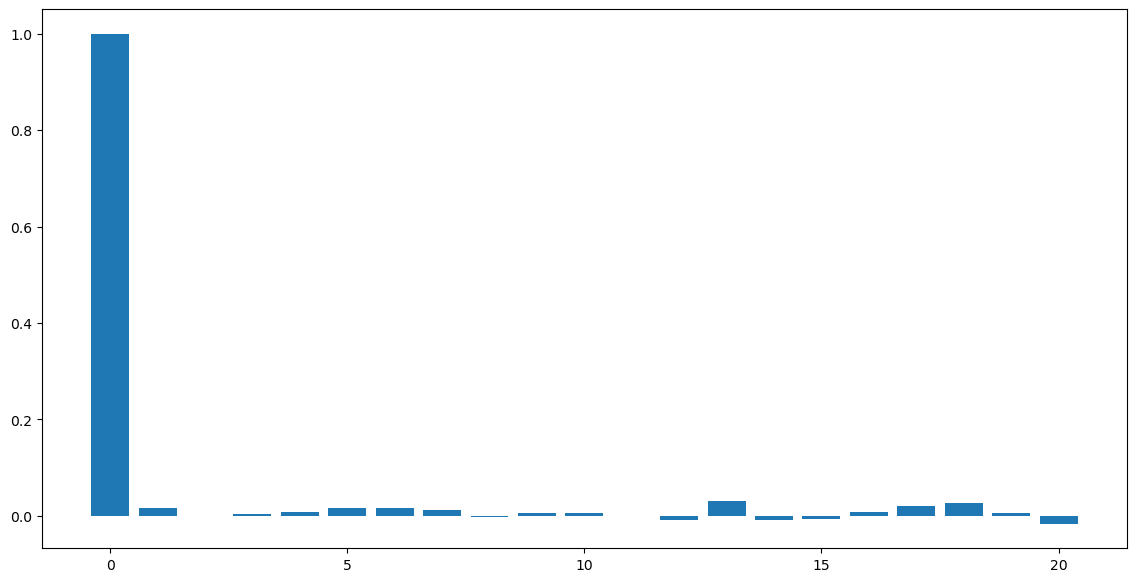

In [64]:
from statsmodels.tsa.stattools import acf

fig, ax = plt.subplots(1, 1, figsize=(14, 7))

lags = 20
ax.bar(range(lags+1), acf(model.resid, nlags=lags))

### Heteroscedasticity


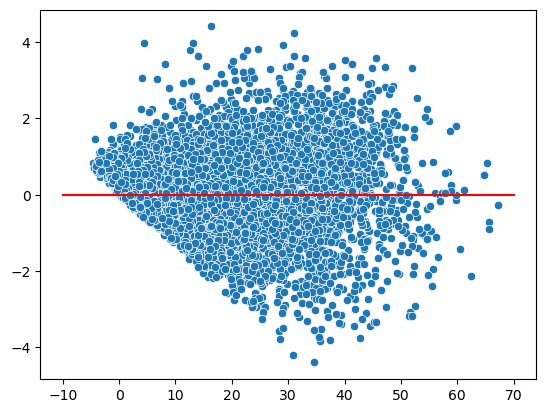

In [65]:
sns.scatterplot(x=model.predict(clean[columns]), y=standardize(model.resid))
plt.plot(np.linspace(-10, 70, 3), [0, 0, 0], 'r')

### Completeness

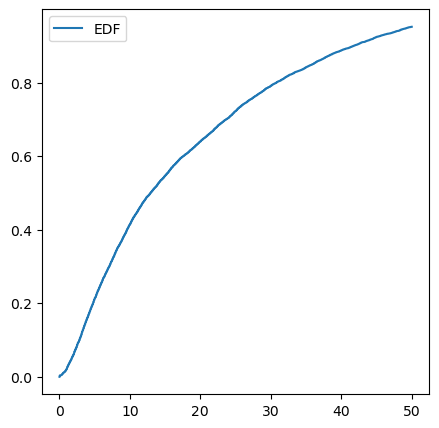

In [66]:
xrange = np.linspace(0, 50, 1000)
sd_la_ecdf= np.array([sum(clean['Education'] < x) for x in xrange]) / len(clean)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(xrange, sd_la_ecdf, label='EDF')
ax.legend()

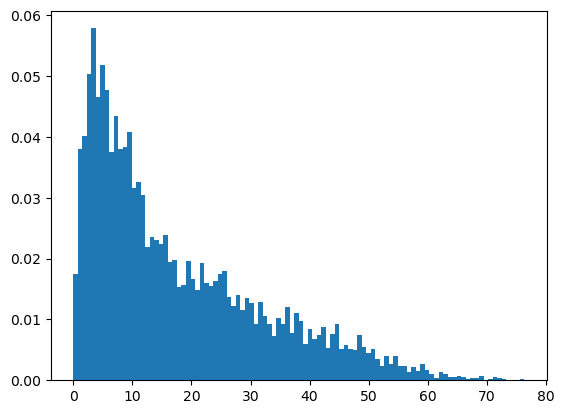

In [67]:
hide = plt.hist(clean['Education'], bins=100, density=True)

In [68]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Education   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     4626.
Date:                Tue, 04 Jun 2024   Prob (F-statistic):               0.00
Time:                        10:49:30   Log-Likelihood:                -26177.
No. Observations:                7672   AIC:                         5.237e+04
Df Residuals:                    7666   BIC:                         5.241e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -8.3005      0.310    -26.770      0.000      -8.908      -7.693
Poverty                  0.3413      0.007     49.675      0.000       0.328       0.355
Lead                     0.1217      0.005     24.751      0.000       0.112       0.131
Asthma                   0.0363      0.003     10.932      0.000       0.030       0.043
Linguistic_Isolation     0.5308      0.011     46.255      0.000       0.508       0.553
Pollution_Burden         0.0496      0.008      6.333      0.000       0.034       0.065
==============================================================================
Omnibus:                      189.152   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              410.103
Skew:                           0.113   Prob(JB):                     8.86e-90
Kurtosis:                       4.110   Cond. No.                         354.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Feature Selection
Instead of using our intuition, we turned to more established techniques for selecting the most meaningful covariates.

In [69]:
criterion = lambda formula, df: smf.ols(formula, data=data).fit().bic

def add(df, selected_columns, columns, criterion, response='y'):
    best_criterion = np.inf
    best_column = None
    for column in columns - selected_columns:
        new_columns = selected_columns.union({column})
        formula = f'{response} ~ {" + ".join(new_columns)}'
        current_criterion = criterion(formula, df)
        if current_criterion < best_criterion:
            best_criterion = current_criterion
            best_column = column
    print(best_column)
    return selected_columns.union({best_column}), best_criterion

def forward(df, criterion, response='y'):
    selected_columns = set()
    columns = set(df.columns.drop(response))
    best_criterion = np.inf
    while len(selected_columns) < len(columns):
        potential_columns, current_criterion = add(df, selected_columns, columns, criterion, response)
        if current_criterion > best_criterion:
            break
        else:
            selected_columns = potential_columns
            best_criterion = current_criterion
            print(f'Criterion: {best_criterion}')
    return selected_columns

forward_vars = forward(data, criterion, response='Education')
forward_vars

Poverty
Criterion: 57280.9320387672
Linguistic_Isolation
Criterion: 53485.54569503719
Unemployment_Pctl
Criterion: 52039.65421107553
CES_40_Score
Criterion: 50901.267380100784
Low_Birth_Weight
Criterion: 50332.96806617885
Pollution_Burden
Criterion: 49737.424332036004
Lead
Criterion: 49359.280023184576
Housing_Burden_Pctl
Criterion: 48847.090839037126
California_County
Criterion: 48442.362361496635
Lead_Pctl
Criterion: 48293.8614095097
Traffic_Pctl
Criterion: 48164.651724308686
Pesticides_Pctl
Criterion: 48047.25937667351
Asthma
Criterion: 47939.396036869795
Pop_Char_Score
Criterion: 47598.062834220684
Poverty_Pctl
Criterion: 47254.54952825292
Cardiovascular_Disease_Pctl
Criterion: 46693.79152929544
Asthma_Pctl
Criterion: 46224.37718929914
Low_Birth_Weight_Pctl
Criterion: 45219.29702091114
Linguistic_Isolation_Pctl
Criterion: 40402.90244407756
CES_40_Percentile_Range
Criterion: 40237.571852205176
Unemployment
Criterion: 40184.08004993615
Longitude
Criterion: 40144.88877455766
Census_Tr

{'Asthma',
 'Asthma_Pctl',
 'CES_40_Percentile_Range',
 'CES_40_Score',
 'California_County',
 'Cardiovascular_Disease_Pctl',
 'Census_Tract',
 'Housing_Burden',
 'Housing_Burden_Pctl',
 'Latitude',
 'Lead',
 'Lead_Pctl',
 'Linguistic_Isolation',
 'Linguistic_Isolation_Pctl',
 'Longitude',
 'Low_Birth_Weight',
 'Low_Birth_Weight_Pctl',
 'Pesticides_Pctl',
 'Pollution_Burden',
 'Pop_Char_Pctl',
 'Pop_Char_Score',
 'Poverty',
 'Poverty_Pctl',
 'Traffic_Pctl',
 'Unemployment',
 'Unemployment_Pctl'}

In [70]:
true_model_formula = 'Education ~ ' + ' + '.join(forward_vars)
model_forward = smf.ols(true_model_formula, data).fit()
model_forward.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Education   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     1302.
Date:                Tue, 04 Jun 2024   Prob (F-statistic):               0.00
Time:                        10:51:06   Log-Likelihood:                -19614.
No. Observations:                7356   AIC:                         3.942e+04
Df Residuals:                    7260   BIC:                         4.008e+04
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                           -9564.4071   2118.479     -4.515      0.000   -1.37e+04   -5411.572
California_County[T.Alpine ]                        -4.093e-05   9.47e-06     -4.320      0.000   -5.95e-05   -2.24e-05
California_County[T.Amador ]                           -1.6525      1.749     -0.945      0.345      -5.082       1.777
California_County[T.Butte ]                            -7.0568      2.117     -3.333      0.001     -11.208      -2.906
California_County[T.Calaveras ]                       -10.7794      2.972     -3.626      0.000     -16.606      -4.953
California_County[T.Colusa ]                          -12.1285      3.745     -3.238      0.001     -19.470      -4.787
California_County[T.Contra Costa]                     -17.4441      4.208     -4.145      0.000     -25.694      -9.194
California_County[T.Del Norte]                      -4.603e-11   1.05e-11     -4.373      0.000   -6.67e-11   -2.54e-11
California_County[T.El Dorado]                        -20.6551      5.519     -3.743      0.000     -31.474      -9.837
California_County[T.Fresno ]                          -24.6612      6.167     -3.999      0.000     -36.750     -12.573
California_County[T.Glenn ]                           -28.3025      7.103     -3.985      0.000     -42.227     -14.378
California_County[T.Humboldt ]                        -34.2310      7.737     -4.424      0.000     -49.398     -19.064
California_County[T.Imperial ]                        -35.0480      8.355     -4.195      0.000     -51.426     -18.670
California_County[T.Inyo ]                            -35.7261      9.114     -3.920      0.000     -53.592     -17.860
California_County[T.Kern ]                            -41.0521      9.671     -4.245      0.000     -60.010     -22.094
California_County[T.Kings ]                           -45.1759     10.397     -4.345      0.000     -65.557     -24.795
California_County[T.Lake ]                            -50.3950     11.182     -4.507      0.000     -72.316     -28.474
California_County[T.Lassen ]                          -44.9429     11.955     -3.759      0.000     -68.378     -21.508
California_County[T.Los Angeles]                      -55.4651     12.643     -4.387      0.000     -80.249     -30.682
California_County[T.Madera ]                          -54.7028     13.215     -4.140      0.000     -80.607     -28.798
California_County[T.Marin ]                           -62.2156     14.012     -4.440      0.000     -89.684     -34.748
California_County[T.Mariposa ]                        -63.5646     14.673     -4.332      0.000     -92.327     -34.802
California_County[T.Mendocino ]                       -69.5633     15.420     -4.51

### Forward Selection Model Analysis

#### Linearity

<BarContainer object of 21 artists>

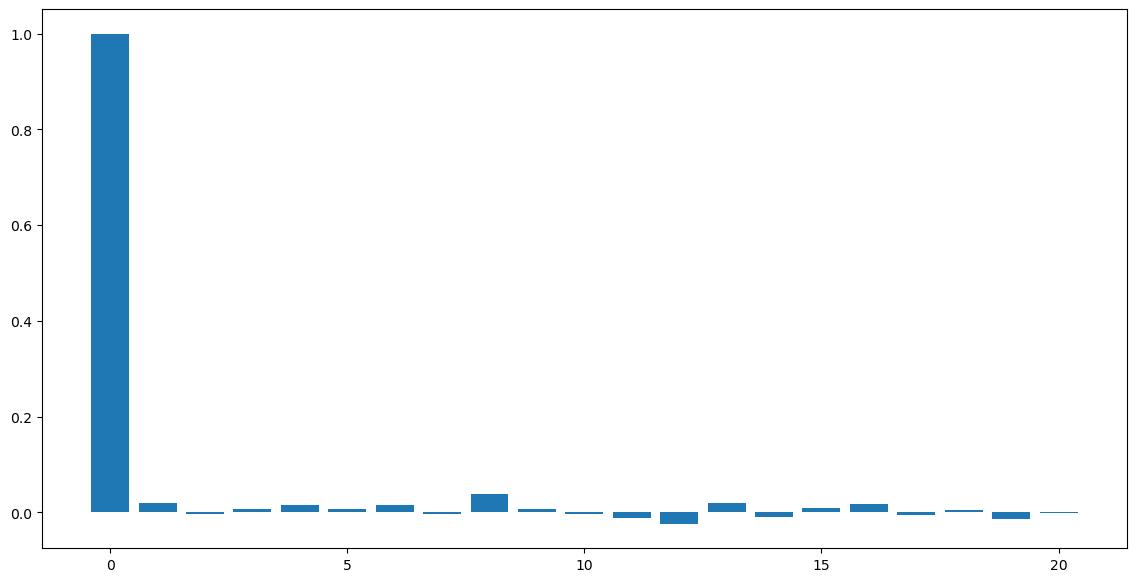

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

lags = 20
ax.bar(range(lags+1), acf(model_forward.resid, nlags=lags))

#### Independence of residuals

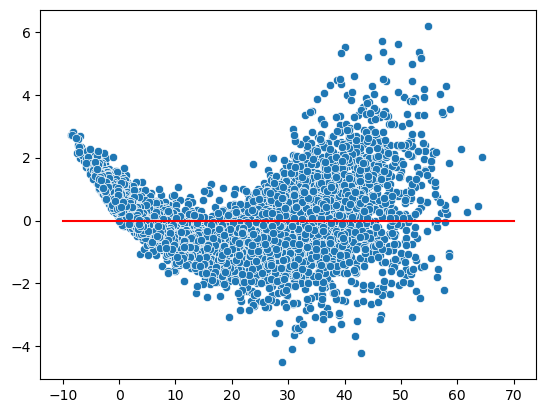

In [72]:
sns.scatterplot(x=model_forward.predict(data), y=standardize(model_forward.resid))
plt.plot(np.linspace(-10, 70, 3), [0, 0, 0], 'r')

In [73]:
forward_vars_cleaned = forward(data_copy, criterion, response='Education')
forward_vars_cleaned

Poverty
Criterion: 57280.9320387672
Linguistic_Isolation
Criterion: 53485.54569503719
Unemployment
Criterion: 52041.31879448832
CES_40_Score
Criterion: 50885.14943420967
Low_Birth_Weight
Criterion: 50320.770162607914
Pollution_Burden
Criterion: 49726.490642077966
Housing_Burden
Criterion: 49350.366752685244
Lead
Criterion: 48868.60357022404
California_County
Criterion: 48503.991961845386
Traffic
Criterion: 48384.09409331213
Asthma
Criterion: 48285.88052833552
Pop_Char_Score
Criterion: 48107.478212581176
CES_40_Percentile_Range
Criterion: 47856.7246812195
Cardiovascular_Disease
Criterion: 47775.95745822265
Total_Population
Criterion: 47737.859111156315
Census_Tract
Criterion: 47709.90454301808
Diesel_PM
Criterion: 47685.57372268009
Pesticides
Criterion: 47664.18914201997
Longitude
Criterion: 47657.92137727841
Solid_Waste
Criterion: 47653.18457575796
Groundwater_Threats
Criterion: 47648.52225150729
Drinking_Water
Criterion: 47646.46234713659
CES_40_Percentile


{'Asthma',
 'CES_40_Percentile_Range',
 'CES_40_Score',
 'California_County',
 'Cardiovascular_Disease',
 'Census_Tract',
 'Diesel_PM',
 'Drinking_Water',
 'Groundwater_Threats',
 'Housing_Burden',
 'Lead',
 'Linguistic_Isolation',
 'Longitude',
 'Low_Birth_Weight',
 'Pesticides',
 'Pollution_Burden',
 'Pop_Char_Score',
 'Poverty',
 'Solid_Waste',
 'Total_Population',
 'Traffic',
 'Unemployment'}

In [74]:
forward_vars_cleaned = forward_vars_cleaned - {'CES_40_Score', 'CES_40_Percentile_Range'}
true_model_formula = 'Education ~ ' + ' + '.join(forward_vars_cleaned)
model_forward_cleaned = smf.ols(true_model_formula, data_copy).fit()
model_forward_cleaned.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Education   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     474.5
Date:                Tue, 04 Jun 2024   Prob (F-statistic):               0.00
Time:                        10:51:49   Log-Likelihood:                -23897.
No. Observations:                7355   AIC:                         4.794e+04
Df Residuals:                    7283   BIC:                         4.843e+04
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                            -2.217e+04   3981.742     -5.568      0.000      -3e+04   -1.44e+04
California_County[T.Alpine ]             0.0001   2.46e-05      5.504      0.000    8.71e-05       0.000
California_County[T.Amador ]            -9.4139      3.222     -2.922      0.003     -15.729      -3.099
California_County[T.Butte ]            -23.1540      3.839     -6.032      0.000     -30.679     -15.629
California_County[T.Calaveras ]        -25.8253      5.564     -4.641      0.000     -36.733     -14.918
California_County[T.Colusa ]           -31.7987      6.953     -4.573      0.000     -45.429     -18.169
California_County[T.Contra Costa]      -41.6402      7.915     -5.261      0.000     -57.156     -26.125
California_County[T.Del Norte]        8.648e-10   1.62e-10      5.335      0.000    5.47e-10    1.18e-09
California_County[T.El Dorado]         -50.5165     10.367     -4.873      0.000     -70.839     -30.194
California_County[T.Fresno ]           -57.6260     11.697     -4.927      0.000     -80.555     -34.697
California_County[T.Glenn ]            -71.9524     13.308     -5.407      0.000     -98.040     -45.865
California_County[T.Humboldt ]         -90.5444     14.444     -6.269      0.000    -118.858     -62.231
California_County[T.Imperial ]         -76.8147     15.654     -4.907      0.000    -107.502     -46.128
California_County[T.Inyo ]             -87.9314     17.159     -5.125      0.000    -121.568     -54.295
California_County[T.Kern ]             -93.9928     18.275     -5.143      0.000    -129.817     -58.168
California_County[T.Kings ]           -105.8268     19.617     -5.395      0.000    -144.282     -67.371
California_County[T.Lake ]            -117.1629     21.068     -5.561      0.000    -158.462     -75.863
California_County[T.Lassen ]          -119.0154     22.406     -5.312      0.000    -162.937     -75.093
California_County[T.Los Angeles]      -124.6448     23.828     -5.231      0.000    -171.354     -77.936
California_County[T.Madera ]          -129.2627     24.936     -5.184      0.000    -178.144     -80.381
California_County[T.Marin ]           -143.2887     26.345     -5.439      0.000    -194.933     -91.645
California_County[T.Mariposa ]        -152.6144     27.650     -5.520      0.000    -206.816     -98.413
California_County[T.Mendocino ]       -163.6406     28.979     -5.647      0.000    -220.447    -106.834
California_County[T.Merced ]          -160.7388     30.240     -5.316      0.000    -220.017    -101.460
California_County[T.Modoc ]           7.002e-13   1.45e-13      4.835      0.000    4.16e-13    9.84e-13
California_County[T.Mono ]            3.069e-12   5.69e-13      5.394      0.000    1.95e-12    4.18e-12
California_County[T.Monterey ]        

## Penalized Regression on All Variables
I think we have to do the regression assumptions for the entire data set

### Lasso Regression On Our Subset

In [75]:
lasso_model = smf.ols('Education ~ Poverty + Lead + Asthma + Linguistic_Isolation + Pollution_Burden', clean).fit_regularized(method='elastic_net', alpha=0.3, L1_wt=1.0)
print(lasso_model.params[lasso_model.params > 1e-2])

Poverty                 0.323336
Lead                    0.112123
Asthma                  0.020446
Linguistic_Isolation    0.580812
dtype: float64


### Lasso Regression On All Variables

In [76]:
all_variables = data.columns
updated_variables = []
excluded_variables = ['Education','CES_40_Score', 'CES_40_Percentile','CES_40_Percentile_Range']
for variable in all_variables:
    if variable in excluded_variables:
        continue
    updated_variables.append(variable)

full_model_formula = 'Education ~ ' + ' + '.join(updated_variables)
full_model_formula
# variables removed: 'Education','CES_40_Score', 'CES_40_Percentile','CES_40_Percentile_Range',
# full_model_formula

'Education ~ ZIP + Longitude + Latitude + Ozone + Lead + Pesticides + Traffic + Asthma + Poverty + Unemployment + Census_Tract + Total_Population + California_County + Approximate_Location + Ozone_Pctl + PM25 + PM25_Pctl + Diesel_PM + Diesel_PM_Pctl + Drinking_Water + Drinking_Water_Pctl + Lead_Pctl + Pesticides_Pctl + Tox_Release + Tox_Release_Pctl + Traffic_Pctl + Cleanup_Sites + Cleanup_Sites_Pctl + Groundwater_Threats + Groundwater_Threats_Pctl + Haz_Waste + Haz_Waste_Pctl + Imp_Water_Bodies + Imp_Water_Bodies_Pctl + Solid_Waste + Solid_Waste_Pctl + Pollution_Burden + Pollution_Burden_Score + Pollution_Burden_Pctl + Asthma_Pctl + Low_Birth_Weight + Low_Birth_Weight_Pctl + Cardiovascular_Disease + Cardiovascular_Disease_Pctl + Linguistic_Isolation + Linguistic_Isolation_Pctl + Poverty_Pctl + Unemployment_Pctl + Housing_Burden + Housing_Burden_Pctl + Pop_Char_ + Pop_Char_Score + Pop_Char_Pctl'

In [77]:
full_lasso_model = smf.ols(full_model_formula, data).fit_regularized(method='elastic_net', alpha=0.3, L1_wt=1.0)
print(full_lasso_model.params[full_lasso_model.params > 1e-2])

Lead                           0.152075
Poverty                        0.334640
PM25_Pctl                      0.052796
Pesticides_Pctl                0.020612
Cleanup_Sites                  0.021718
Pollution_Burden               0.082069
Pollution_Burden_Pctl          0.035027
Cardiovascular_Disease_Pctl    0.024144
Linguistic_Isolation           0.395488
Linguistic_Isolation_Pctl      0.033711
Pop_Char_                      0.125940
Pop_Char_Pctl                  0.066458
dtype: float64


### Elastic Net on Our Subset

In [80]:
elastic_net_model = smf.ols('Education ~ Poverty + Lead + Asthma + Linguistic_Isolation + Pollution_Burden', clean).fit_regularized(method='elastic_net', alpha=0.3, L1_wt=.5)
print(elastic_net_model.params[elastic_net_model.params > 1e-2])

Poverty                 0.326383
Lead                    0.112683
Asthma                  0.019684
Linguistic_Isolation    0.578014
dtype: float64


### Elastic Net Model On All Variables

In [81]:
full_elastic_net_model = smf.ols(full_model_formula,data).fit_regularized(method='elastic_net', alpha=0.3, L1_wt=.5)
print(full_elastic_net_model.params[full_elastic_net_model.params > 1e-2])

Lead                           0.153410
Poverty                        0.338333
PM25_Pctl                      0.052504
Pesticides_Pctl                0.020778
Cleanup_Sites                  0.018522
Haz_Waste                      0.181297
Pollution_Burden               0.086027
Pollution_Burden_Pctl          0.032047
Cardiovascular_Disease_Pctl    0.028332
Linguistic_Isolation           0.401552
Linguistic_Isolation_Pctl      0.033921
Unemployment_Pctl              0.010076
Pop_Char_                      0.124854
Pop_Char_Pctl                  0.064584
dtype: float64


It seems that lasso regression and elastic net regression both select the same variables.

### Regression Model Using Variables Selected by Lasso and Elastic

In [86]:
selected_variables_lasso = ['Lead','Poverty','PM25_Pctl', 'Pesticides_Pctl', 'Cleanup_Sites', 'Pollution_Burden' , 'Pollution_Burden_Pctl' ,        
'Cardiovascular_Disease_Pctl', 'Linguistic_Isolation', 'Linguistic_Isolation_Pctl', 'Pop_Char_','Pop_Char_Pctl']

selected_variables_elastic = ['Lead','Poverty', 'PM25_Pctl', 'Pesticides_Pctl', 'Cleanup_Sites','Haz_Waste', 'Pollution_Burden','Pollution_Burden_Pctl',          
'Cardiovascular_Disease_Pctl', 'Linguistic_Isolation', 'Linguistic_Isolation_Pctl', 'Unemployment_Pctl', 'Pop_Char_', 'Pop_Char_Pctl']

In [87]:
selected_variables_lasso == selected_variables_elastic

False

The variables returned by selected lasso and elastic net are different

In [88]:
lasso_formula = 'Education ~ ' + ' + '.join(selected_variables_lasso)
elastic_formula = 'Education ~ ' + ' + '.join(selected_variables_elastic)

In [89]:
model_lasso = smf.ols(lasso_formula, data).fit()
model_lasso.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Education   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     2312.
Date:                Tue, 04 Jun 2024   Prob (F-statistic):               0.00
Time:                        11:27:21   Log-Likelihood:                -25639.
No. Observations:                7672   AIC:                         5.130e+04
Df Residuals:                    7659   BIC:                         5.139e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                     -13.1911      1.126    -11.715      0.000     -15.398     -10.984
Lead                            0.1426      0.005     29.123      0.000       0.133       0.152
Poverty                         0.2156      0.009     25.322      0.000       0.199       0.232
PM25_Pctl                       0.0285      0.004      7.276      0.000       0.021       0.036
Pesticides_Pctl                 0.0582      0.003     19.606      0.000       0.052       0.064
Cleanup_Sites                   0.0170      0.006      2.944      0.003       0.006       0.028
Pollution_Burden                0.1061      0.040      2.630      0.009       0.027       0.185
Pollution_Burden_Pctl          -0.0714      0.018     -4.071      0.000      -0.106      -0.037
Cardiovascular_Disease_Pctl     0.0268      0.005      5.448      0.000       0.017       0.036
Linguistic_Isolation            0.4508      0.019     24.121      0.000       0.414       0.487
Linguistic_Isolation_Pctl       0.0217      0.006      3.397      0.001       0.009       0.034
Pop_Char_                       0.1033      0.051      2.015      0.044       0.003       0.204
Pop_Char_Pctl                   0.0294      0.036      0.818      0.414      -0.041       0.100
==============================================================================
Omnibus:                      187.483   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              361.884
Skew:                           0.168   Prob(JB):                     2.62e-79
Kurtosis:                       4.010   Cond. No.                     2.22e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [90]:
model_elastic = smf.ols(lasso_formula, data).fit()
model_elastic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Education   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     2312.
Date:                Tue, 04 Jun 2024   Prob (F-statistic):               0.00
Time:                        11:27:24   Log-Likelihood:                -25639.
No. Observations:                7672   AIC:                         5.130e+04
Df Residuals:                    7659   BIC:                         5.139e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                     -13.1911      1.126    -11.715      0.000     -15.398     -10.984
Lead                            0.1426      0.005     29.123      0.000       0.133       0.152
Poverty                         0.2156      0.009     25.322      0.000       0.199       0.232
PM25_Pctl                       0.0285      0.004      7.276      0.000       0.021       0.036
Pesticides_Pctl                 0.0582      0.003     19.606      0.000       0.052       0.064
Cleanup_Sites                   0.0170      0.006      2.944      0.003       0.006       0.028
Pollution_Burden                0.1061      0.040      2.630      0.009       0.027       0.185
Pollution_Burden_Pctl          -0.0714      0.018     -4.071      0.000      -0.106      -0.037
Cardiovascular_Disease_Pctl     0.0268      0.005      5.448      0.000       0.017       0.036
Linguistic_Isolation            0.4508      0.019     24.121      0.000       0.414       0.487
Linguistic_Isolation_Pctl       0.0217      0.006      3.397      0.001       0.009       0.034
Pop_Char_                       0.1033      0.051      2.015      0.044       0.003       0.204
Pop_Char_Pctl                   0.0294      0.036      0.818      0.414      -0.041       0.100
==============================================================================
Omnibus:                      187.483   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              361.884
Skew:                           0.168   Prob(JB):                     2.62e-79
Kurtosis:                       4.010   Cond. No.                     2.22e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Regression Assumptions for Lasso

### Independence

<BarContainer object of 21 artists>

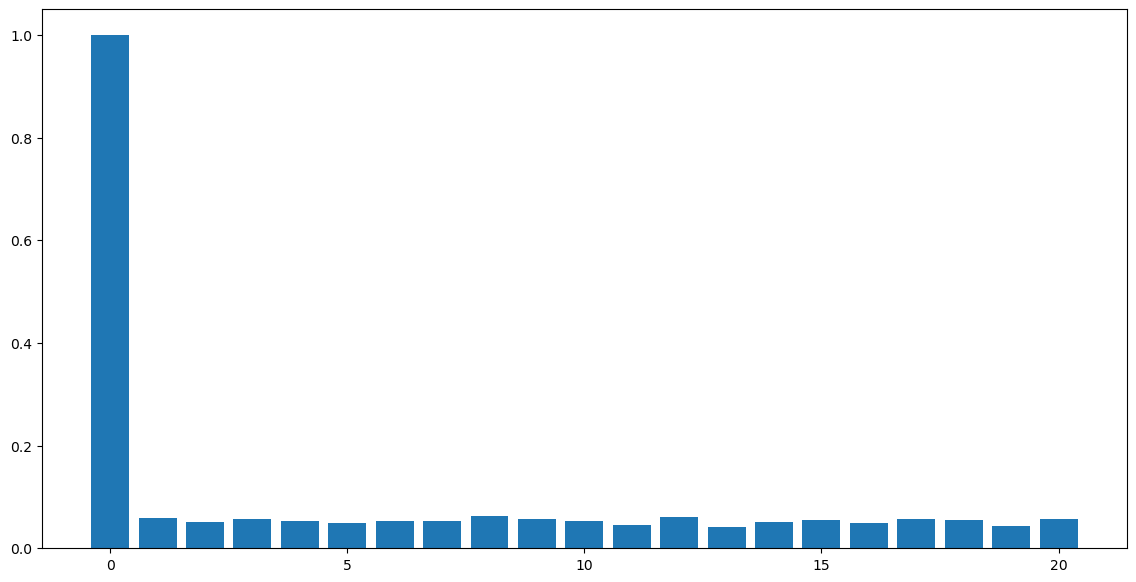

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

lags = 20
ax.bar(range(lags+1), acf(model_lasso.resid, nlags=lags))

### Heteroscadiscity

<Axes: >

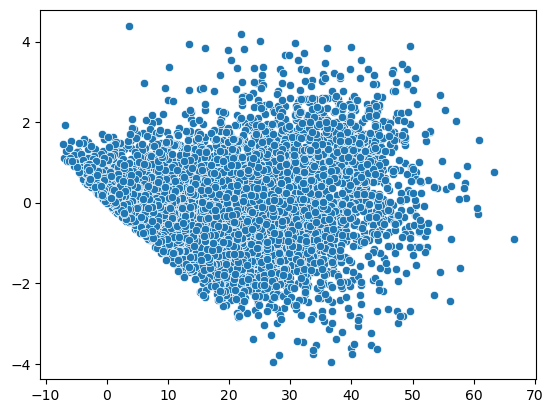

In [92]:
sns.scatterplot(x=model_lasso.predict(data[selected_variables_lasso]), y=standardize(model_lasso.resid))

### Normality of Residuals

(array([0.00312323, 0.        , 0.00468484, 0.00312323, 0.00156161,
        0.00468484, 0.00624646, 0.        , 0.00312323, 0.00156161,
        0.00312323, 0.00624646, 0.00468484, 0.01249291, 0.0109313 ,
        0.01405452, 0.0109313 , 0.01561614, 0.02030098, 0.03435551,
        0.02498582, 0.04060196, 0.03904035, 0.05153326, 0.05153326,
        0.05777971, 0.07339585, 0.08276554, 0.07651908, 0.10775136,
        0.12024427, 0.13586041, 0.15616139, 0.15147655, 0.20144819,
        0.2248724 , 0.2701592 , 0.25454306, 0.33418537, 0.29982986,
        0.31856923, 0.37947217, 0.37947217, 0.43100543, 0.42319736,
        0.49815483, 0.48566191, 0.45130641, 0.48878514, 0.46848416,
        0.45755286, 0.38415701, 0.35760958, 0.37322572, 0.32325407,
        0.28889857, 0.29982986, 0.25766629, 0.26391274, 0.20457142,
        0.17490075, 0.15459977, 0.11399781, 0.13273718, 0.08901199,
        0.09994329, 0.09525845, 0.07495747, 0.09682006, 0.05465649,
        0.05777971, 0.04684842, 0.03591712, 0.02

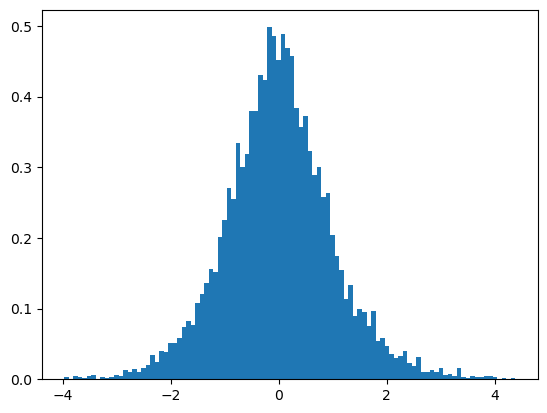

In [93]:
plt.hist(standardize(model_lasso.resid), bins=100, density=True)

## Regression Assumptions for Elastic

### Independence

<BarContainer object of 21 artists>

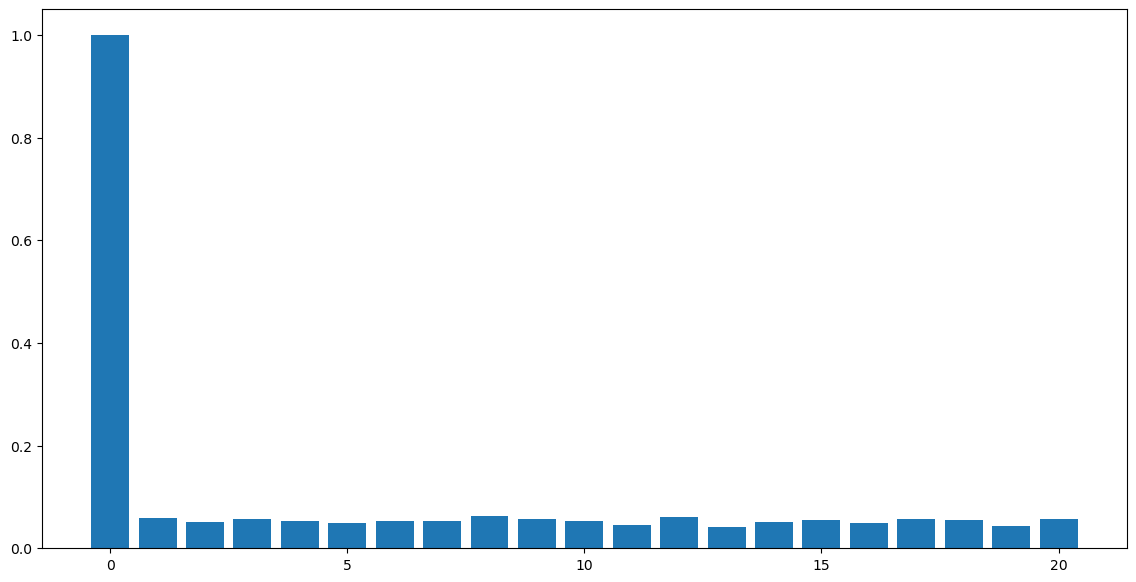

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

lags = 20
ax.bar(range(lags+1), acf(model_elastic.resid, nlags=lags))

### Heteroscadiscity

<Axes: >

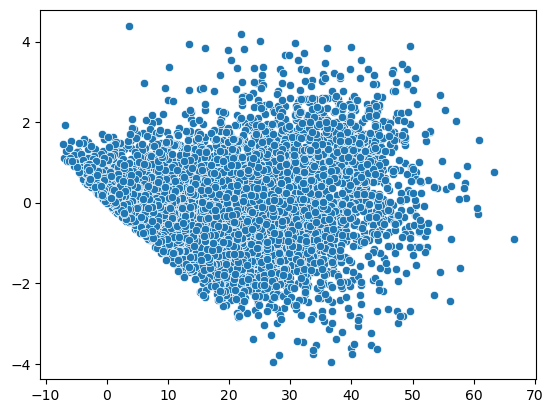

In [95]:
sns.scatterplot(x=model_elastic.predict(data[selected_variables_elastic]), y=standardize(model_elastic.resid))

### Normality of Residuals

(array([0.00312323, 0.        , 0.00468484, 0.00312323, 0.00156161,
        0.00468484, 0.00624646, 0.        , 0.00312323, 0.00156161,
        0.00312323, 0.00624646, 0.00468484, 0.01249291, 0.0109313 ,
        0.01405452, 0.0109313 , 0.01561614, 0.02030098, 0.03435551,
        0.02498582, 0.04060196, 0.03904035, 0.05153326, 0.05153326,
        0.05777971, 0.07339585, 0.08276554, 0.07651908, 0.10775136,
        0.12024427, 0.13586041, 0.15616139, 0.15147655, 0.20144819,
        0.2248724 , 0.2701592 , 0.25454306, 0.33418537, 0.29982986,
        0.31856923, 0.37947217, 0.37947217, 0.43100543, 0.42319736,
        0.49815483, 0.48566191, 0.45130641, 0.48878514, 0.46848416,
        0.45755286, 0.38415701, 0.35760958, 0.37322572, 0.32325407,
        0.28889857, 0.29982986, 0.25766629, 0.26391274, 0.20457142,
        0.17490075, 0.15459977, 0.11399781, 0.13273718, 0.08901199,
        0.09994329, 0.09525845, 0.07495747, 0.09682006, 0.05465649,
        0.05777971, 0.04684842, 0.03591712, 0.02

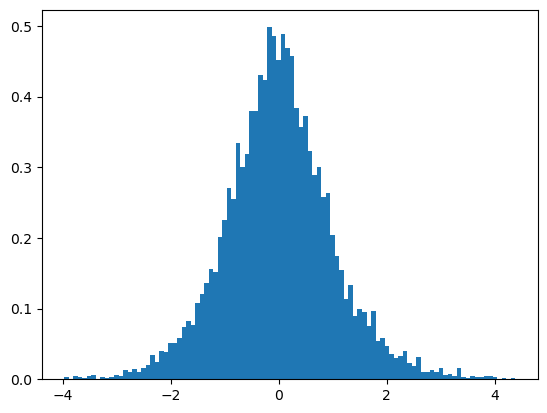

In [96]:
plt.hist(standardize(model_elastic.resid), bins=100, density=True)

Given the model's complexity's are relatively similar, it is expected to see that they both perform the same in terms of meeting the regression assumptions.